# Explicit implementation of score-based generative modeling

In [4]:
import matplotlib.pyplot as plt
import os
import torch
import torch.optim as optim
import torch.nn as nn
import lib.toy_data as toy_data
import numpy as np
import argparse



### Parsing for scripts

In [87]:
parser = argparse.ArgumentParser('simple_sgm_experiments')
parser.add_argument('--data', choices=['swissroll', '8gaussians', 'pinwheel', 'circles', 'moons', '2spirals', 'checkerboard', 'rings'], type = str,default = 'moons')
parser.add_argument('--depth',help = 'number of hidden layers of score network',type =int, default = 7)
parser.add_argument('--hiddenunits',help = 'number of nodes per hidden layer', type = int, default = 32)
parser.add_argument('--niters',type = int, default = 100000)
parser.add_argument('--batch_size', type = int,default = 64)
parser.add_argument('--lr',type = float, default = 1e-3) 
parser.add_argument('--finalT',type = float, default = 5)
parser.add_argument('--dt',type = float,help = 'integrator step size', default = 0.001)
parser.add_argument('--save',type = str,default = 'experiments/simple_sgm/')

_StoreAction(option_strings=['--save'], dest='save', nargs=None, const=None, default='experiments/simple_sgm/', type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

In [92]:
args = parser.parse_args('')

### Score estimators

In [169]:
def ou_kernel(x,y,t):
    d = 2
    log_kernel = - torch.sum((x-y* torch.exp(-0.5* t))**2,1) / (2 * (1-torch.exp(-t))) 
    output = 1/torch.sqrt((2*torch.pi) ** d  * (1-torch.exp(-t))**2) * torch.exp(log_kernel)
    return output 


def kernel_score(x,data,t):
    numerator = -(x-data* torch.exp(-0.5* t))/(2*(1-torch.exp(-t))**2) * ou_kernel(x,data,t)[:,None]
    denom = ou_kernel(x,data,t)
    return  torch.sum(numerator,0)/ torch.sum(denom,0)





In [170]:
dataset = 'checkerboard'
p_samples = toy_data.inf_train_gen(dataset, batch_size = 10000)
training_samples = torch.tensor(p_samples).to(dtype = torch.float32)

### SDE Dynamics functions

In [187]:
def ou_dynamics(init, T):
    '''
    Solves the OU process exactly given deterministic initial condition `init` and final time `T`
    '''
    return init * torch.exp(- 0.5 * T) + torch.sqrt(1-torch.exp(-T)) * torch.randn_like(init)

def reverse_sde(score, init,T,lr=args.dt):
    '''
    Given learned score function `score`, reverses random datapoints `init`
    '''
    step = int(T/lr) 
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + score(evalpoint).detach() )
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init

def reverse_ode_flow(score,init,T,lr = args.dt):
    '''
    The deterministic ODE flow that can also sample from the target distribution
    '''
    step = int(T/lr)
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + 1/2 * score(evalpoint).detach())
    return init





def reverse_sde_kernel(score, training_samples,init,T,lr=10*args.dt):
    '''
    Given learned score function `score`, reverses random datapoints `init`
    '''
    step = int(T/lr) 
    for i in range(step,1,-1):
        current_lr = lr
        init = init + current_lr  * (init/2 + score(init,training_samples,torch.tensor(lr*i)).detach() )
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init

In [196]:
T = 3
generated_samples = np.zeros([10000,2])

for i in range(10000):
    noise = torch.randn(1, 2) 
    generated_samples[i,:] = reverse_sde_kernel(kernel_score,training_samples, noise, torch.tensor(T)).detach().numpy()


KeyboardInterrupt: 

In [197]:
generated_samples

array([[-2.56924772, -3.38978887],
       [ 2.63771963, -1.04417968],
       [-1.12779808,  2.51143527],
       ...,
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

(-4.0, 4.0, -4.0, 4.0)

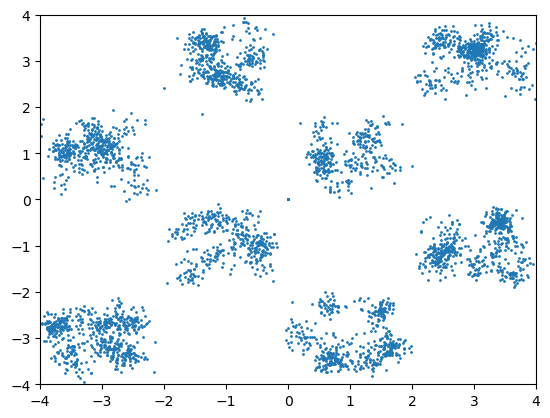

In [198]:
plt.scatter(generated_samples[:,0],generated_samples[:,1],s = 1)
plt.axis([-4,4,-4,4])
# plt.scatter(training_samples[:,0],training_samples[:,1])

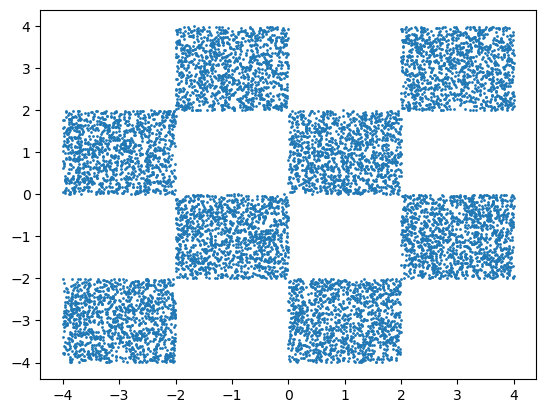

In [195]:
plt.scatter(training_samples[0:10000,0],training_samples[0:10000,1],s=1)


In [139]:
range(10000,-1,10)

range(10000, -1, 10)